<a name='1'></a>
## 1 - Packages

Go ahead and run the cell below to import the packages you'll need.

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
from PIL import Image
import mtcnn
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='3'></a>
## 2 - Encoding Face Images into a 128-Dimensional Vector


### Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, you'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation has been provided for you, and you can find it in the file `inception_blocks_v2.py` to get a closer look at how it is implemented.

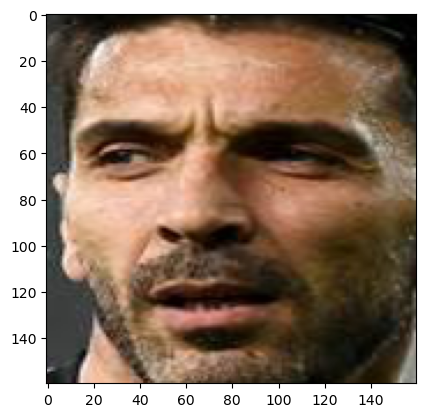

(160, 160, 3)


In [186]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = mtcnn.MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('team_images/Buffon_0.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [187]:
from tensorflow.keras.models import model_from_json

json_file = open('keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('keras-facenet-h5/model.h5')

In [188]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_7:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm_6/add_1:0' shape=(None, 128) dtype=float32>]


<a name='3'></a>
##  3 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. Since training requires a lot of data and computation I m not going to train here I will use pretrained model.

In [189]:
FRmodel = model

<a name='4'></a>
## Applying the Model

I am building a system for an dream soccer team where the FIFA would like to offer facial recognition to allow the best players to enter the building.

At the phase every best player has their Id card and swipe it then system will let them in. In Face recognition literature, there are two main things those are face verification and face recognition.  face verification is a one to one problem where you just want to know if the person is the person they claim to be.So you're given an input image as well as a name or ID of a person and the job of the system is to verify whether or not the input image is that of the claimed person. face recognition is harder than face recogniton because let say you have database and it has 20K people and you system has to recognize the person and output ID person if he/she is one of  20K or not recognized. So in the face recognition system doesn't has the ID in the begining.

<a name='4-1'></a>
### 4.1 - Face Verification

Let's build our the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [190]:
def img_to_encoding1(face_array, model):
    
    img = np.around(np.array(face_array) / 255.0, decimals=12)
    # (160, 160, 3) this image shape but algoritm need  this (1, 160, 160, 3) shape
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [199]:
database = {}
database["Pele"] = img_to_encoding1(extract_face("team_images/Pele_0.jpg"), FRmodel)
database["Gianluigi Buffon"] = img_to_encoding1(extract_face("team_images/Buffon_0.jpg"), FRmodel)
database["Zinedine Zidane"] = img_to_encoding1(extract_face("team_images/Zidane_0.jpg"), FRmodel)
database["Michel Platini"] = img_to_encoding1(extract_face("team_images/Platini_0.jpg"), FRmodel)
database["Ronaldo Nazario"] = img_to_encoding1(extract_face("team_images/Ronaldo_0.jpg"), FRmodel)
database["Johan Cruyff"] = img_to_encoding1(extract_face("team_images/Cruyff_1.jpg"), FRmodel)
database["Kylian Mbappe"] = img_to_encoding1(extract_face("team_images/Mbappe_0.jpg"), FRmodel)
database["Diego Maradona"] = img_to_encoding1(extract_face("team_images/Maradona_0.jpg"), FRmodel)
database["Cristiano Ronaldo"] = img_to_encoding1(extract_face("team_images/CRonaldo_0.jpg"), FRmodel)
database["Lionel Messi"] = img_to_encoding1(extract_face("team_images/Messi_1.jpg"), FRmodel)
database["Paolo Maldini"] = img_to_encoding1(extract_face("team_images/Maldini_0.jpg"), FRmodel)


### Verify

* When someone shows up at your front door and swipes their ID card and giving you their name, We check our database to verify whether is it that person or not.

In [195]:
# UNQ_C2(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- Pretained Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    
    # Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding1(extract_face(image_path), model)
    # Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(database[identity] - encoding) 
    # Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist <0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
       
    return dist, door_open

In [198]:
verify("team_images/Zidane_1.jpg", "Zinedine Zidane", database, FRmodel)

It's Zinedine Zidane, welcome in!


(0.6351629, True)

<a name='5'></a>
### 5- Face Recognition

Our face verification system is mostly working.

In [204]:
# UNQ_C3(UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: who_is_it

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding =  img_to_encoding1(extract_face(image_path), model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(db_enc - encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    ### END CODE HERE
    
    if min_dist > 0.8:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [206]:
who_is_it("team_images/Ronaldo_0.jpg", database, FRmodel)

it's Ronaldo Nazario, the distance is 0.0


(0.0, 'Ronaldo Nazario')

In [213]:
import pickle 

with open('database.pkl', 'wb') as f:
    pickle.dump(database, f)
        
# with open('database.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

In [214]:
print(loaded_dict)

{'Pele': array([[-2.2903763e-02,  6.9708996e-02,  8.5744811e-03,  7.1436339e-03,
        -9.0557799e-02, -8.9903288e-02, -1.3751860e-01, -3.8790356e-02,
         1.5173102e-04, -1.5265369e-01,  1.8683821e-02,  5.9154756e-02,
        -3.2479178e-02, -1.9736808e-02,  2.0289087e-01,  5.7032354e-02,
         1.3034910e-02,  1.0930052e-01, -1.6791840e-01,  9.5880419e-02,
        -1.1110311e-01,  3.8686793e-02, -4.7490798e-02,  1.1696570e-01,
        -1.3400450e-01,  3.5483383e-02, -5.6072097e-02, -3.0754595e-03,
         8.0709986e-02,  6.5419696e-02, -3.5037976e-02,  4.8055425e-02,
        -7.5482223e-03,  4.4376343e-02,  1.8859170e-02,  7.5800210e-02,
        -2.8785983e-02, -1.2490024e-01,  1.0012208e-02,  1.8015167e-02,
         9.0402151e-03, -7.0628449e-03,  6.4856656e-02, -2.5153574e-02,
         1.8949072e-01,  6.4000577e-02,  1.9791970e-01, -1.7303801e-01,
         1.2221964e-02, -1.7900957e-02,  8.8056296e-02, -3.5304535e-02,
         3.2616667e-02, -1.3983609e-01,  3.5141669e-02,

In [215]:
FRmodel.save("Facereg.h5")